In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2

from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    BatchNormalization, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
)
from tensorflow.keras import backend as K
import os
import seaborn as sns
from keras.applications.vgg16 import VGG16

# Importing data

In [3]:
data_dir = "../input/inputimages/field"

root, dirs, files = next(os.walk(data_dir), ([],[],[]))
dirs.sort()
print(len(dirs))

184


# Resising the image

In [6]:
def resize(fl, img_height, img_width):
    img = cv2.imread(fl)
    resized = cv2.resize(img, (img_height, img_width))
    return resized

# Making Data

In [7]:
def get_data():
    X = []
    y = []
    classes = []
    dir_names = []
    
    for dir_name in dirs[:30]:
        class_name = dir_name.replace('_','')
        classes.append(class_name)
        
        dir_names.append(dir_name)
        
        path = os.path.join(data_dir,dir_name,'*.jpg')
        images = glob.glob(path)
        
        for fl in images:
            flbase = os.path.basename(fl)
            img = resize(fl, 120, 120)
            X.append(img)
            y.append(class_name)
            
    return X, y, classes,dir_names

In [8]:
images, labels, classes,dir_names = get_data()

In [9]:
#Convert lists to arrays        
images = np.array(images)
labels = np.array(labels)

# Transforming labels to numerical using label encoder

In [10]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
le = preprocessing.LabelEncoder()
le.fit(labels)
train_labels_encoded = le.transform(labels)

#Split data into test and train datasets (already split but assigning to meaningful convention)
x_train,x_test,y_train, y_test = train_test_split(images, train_labels_encoded, test_size=0.3, random_state=0)


# VGG

In [11]:
SIZE=120
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))

#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in VGG_model.layers:
	layer.trainable = False
    
VGG_model.summary()  #Trainable parameters will be 0


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120, 120, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 120, 120, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 120, 120, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 60, 60, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 60, 60, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 60, 60, 128)       147584    
______________________________________________________________

In [13]:
feature_extractor=VGG_model.predict(x_train)


In [14]:
features = feature_extractor.reshape(feature_extractor.shape[0], -1)

X_for_SVM = features #This is our X input to RF

# SVM with features extracted using VGG

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
  
# defining parameter range
param_grid = {'C': [0.01, 0.1, 1, 10, 100, 1000] }
  
grid_linear = GridSearchCV(SVC(kernel = 'linear'), param_grid, refit = True, verbose = 3,cv=10)
  
# fitting the model for grid search
grid_linear.fit(X_for_SVM,y_train)

# print best parameter after tuning
print(grid_linear.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(grid_linear.best_estimator_)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
[CV] C=0.01 ..........................................................


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, score=0.987, total=   3.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.2s remaining:    0.0s


[CV] .............................. C=0.01, score=0.960, total=   3.2s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.4s remaining:    0.0s


[CV] .............................. C=0.01, score=0.920, total=   3.2s
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=0.920, total=   3.2s
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=0.932, total=   3.2s
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=0.892, total=   3.2s
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=0.919, total=   3.2s
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=0.919, total=   3.2s
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=0.892, total=   3.2s
[CV] C=0.01 ..........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  3.2min finished


{'C': 0.01}
SVC(C=0.01, kernel='linear')


In [16]:

X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
y_pred = grid_linear.predict(X_test_features)


In [19]:
y_pred = le.inverse_transform(y_pred)
y_test = le.inverse_transform(y_test)

In [20]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test,y_pred))

                         precision    recall  f1-score   support

          abiesconcolor       1.00      1.00      1.00        18
      abiesnordmanniana       1.00      1.00      1.00         9
          acercampestre       0.71      1.00      0.83         5
            acerginnala       0.75      0.86      0.80         7
            acergriseum       0.85      1.00      0.92        11
            acernegundo       0.86      0.86      0.86         7
           acerpalmatum       1.00      0.94      0.97        33
      acerpensylvanicum       1.00      1.00      1.00         7
        acerplatanoides       0.73      1.00      0.84         8
     acerpseudoplatanus       1.00      0.50      0.67         4
             acerrubrum       1.00      0.88      0.94        17
        acersaccharinum       1.00      1.00      1.00        13
          acersaccharum       1.00      0.67      0.80         9
          aesculusflava       1.00      1.00      1.00         3
         aesculusglabra 

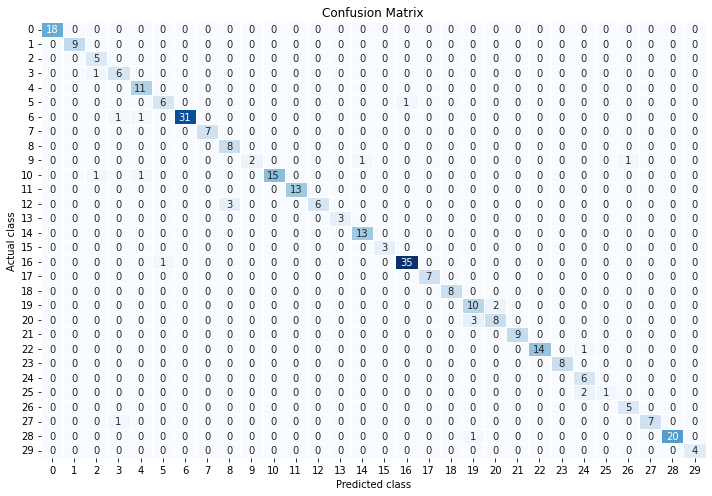

In [21]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, roc_curve, auc
from matplotlib.colors import ListedColormap
import seaborn as sns
fig, ax1 = plt.subplots(1,1, figsize=(10, 7))
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True, cbar = False, fmt = "d", linewidths = .5, cmap = "Blues", ax = ax1)
ax1.set_title("Confusion Matrix")
ax1.set_xlabel("Predicted class")
ax1.set_ylabel("Actual class")
fig.tight_layout()

In [24]:
import pandas as pd

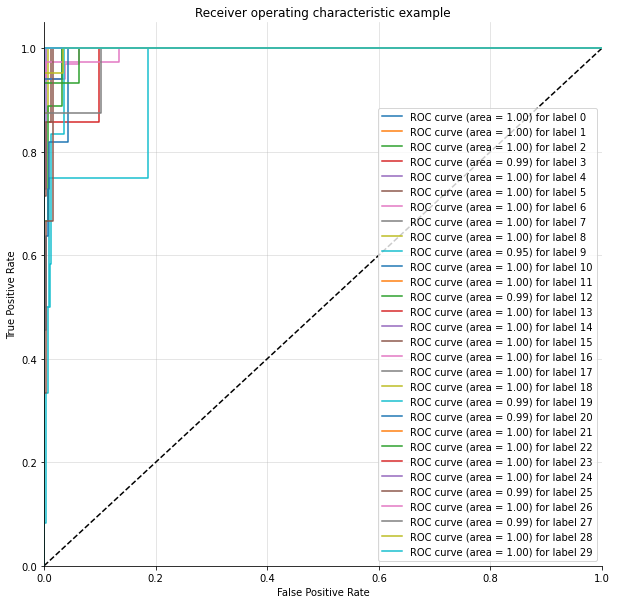

<Figure size 432x288 with 0 Axes>

In [25]:
def plot_multiclass_roc_svm(clf, X_test, y_test, n_classes, figsize=(17, 6)):
    y_score = clf.decision_function(X_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()
    plt.savefig('resnet_knn_roc.png')
plot_multiclass_roc_svm(grid_linear, X_test_features, y_test, n_classes=30, figsize=(10, 10))

Text(0, 0.5, 'Mean Test Score of training data')

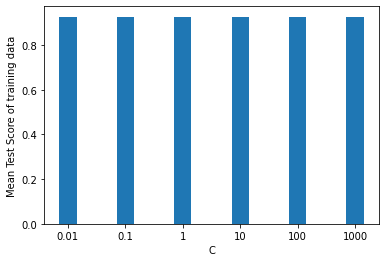

In [26]:
#bar plot for linear svm 
d1=[0.01,0.1, 1, 10, 100, 1000]
scores_linear =  grid_linear.cv_results_['mean_test_score']
x=[]
for i in range(len(d1)):
    x.append(str(d1[i]))
scores = list(scores_linear)
plt.bar(x, scores, width = 0.3)
plt.xlabel('C')
plt.ylabel('Mean Test Score of training data')

# KNN

In [27]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
clf_knn = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1, 30) }
knn_gridcv = GridSearchCV(clf_knn, param_grid ,cv=10, refit = True,n_jobs= -1)
knn_gridcv.fit(X_for_SVM,y_train)
knn_gridcv.best_params_

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


{'n_neighbors': 1}

In [28]:
#Classification Report
from sklearn.metrics import classification_report, confusion_matrix
grid_predictin_random= knn_gridcv.predict(X_test_features)


In [30]:
grid_predictin_random = le.inverse_transform(grid_predictin_random)

In [31]:
print(classification_report(y_test,grid_predictin_random))

                         precision    recall  f1-score   support

          abiesconcolor       1.00      1.00      1.00        18
      abiesnordmanniana       1.00      1.00      1.00         9
          acercampestre       0.67      0.80      0.73         5
            acerginnala       0.83      0.71      0.77         7
            acergriseum       0.85      1.00      0.92        11
            acernegundo       0.83      0.71      0.77         7
           acerpalmatum       1.00      0.94      0.97        33
      acerpensylvanicum       1.00      1.00      1.00         7
        acerplatanoides       0.73      1.00      0.84         8
     acerpseudoplatanus       1.00      0.25      0.40         4
             acerrubrum       0.78      0.82      0.80        17
        acersaccharinum       0.76      1.00      0.87        13
          acersaccharum       0.60      0.33      0.43         9
          aesculusflava       1.00      0.67      0.80         3
         aesculusglabra 

Text(0, 0.5, 'Cross-validated accuracy')

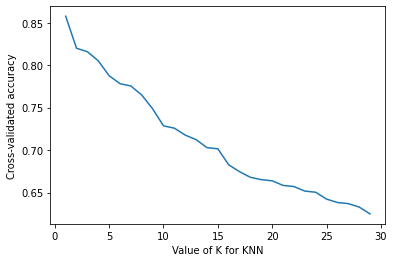

In [32]:
k_range = range(1, 30)
k_scores = knn_gridcv.cv_results_['mean_test_score']
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-validated accuracy')

In [35]:
def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(17, 6)):
    y_score = clf.predict_proba(X_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()
    plt.savefig('resnet_knn_roc.png')

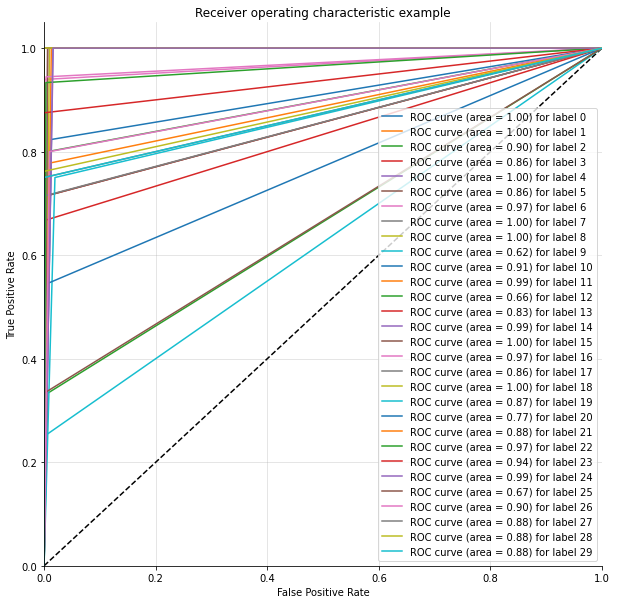

<Figure size 432x288 with 0 Axes>

In [36]:
import pandas as pd
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, roc_curve, auc
plot_multiclass_roc(knn_gridcv, X_test_features, y_test, n_classes=30, figsize=(10, 10))

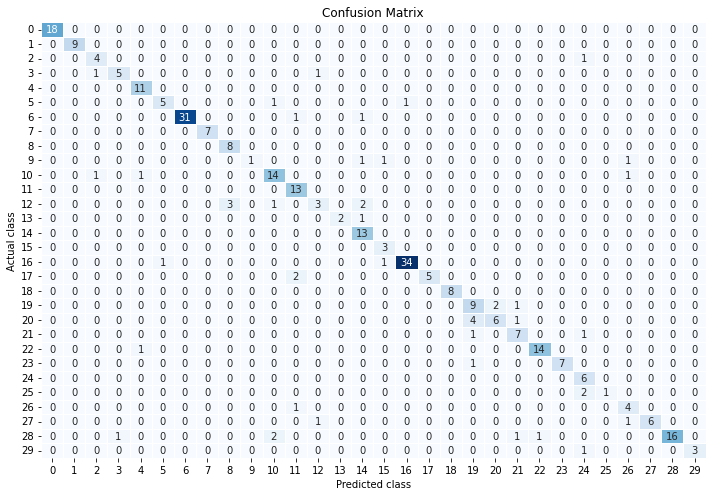

In [37]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, roc_curve, auc
from matplotlib.colors import ListedColormap
import seaborn as sns
fig, ax1 = plt.subplots(1,1, figsize=(10, 7))
# Plot confusion matrix
cm = confusion_matrix(y_test,grid_predictin_random)
sns.heatmap(cm, annot = True, cbar = False, fmt = "d", linewidths = .5, cmap = "Blues", ax = ax1)
ax1.set_title("Confusion Matrix")
ax1.set_xlabel("Predicted class")
ax1.set_ylabel("Actual class")
fig.tight_layout()